In [9]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.layers import AveragePooling2D, Dense, Dropout, Flatten, Input
from sklearn.preprocessing import LabelBinarizer
from keras.models import Model
from keras.optimizers import Adam
from keras.models import load_model
from sklearn.metrics import classification_report
from keras.applications import EfficientNetB0
from imutils import paths
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import pickle

In [10]:
LABELS = set(["Fusarium Head Blight", "Healthy Wheat", "Leaf Rust", "Tan Spot"])
imagePaths = list(paths.list_images('C:/Users/Aycha/Desktop/ept/Traitimages/DATASET'))
data = []
labels = []
for imagePath in imagePaths:
  label = imagePath.split(os.path.sep)[-2]
  if label not in LABELS:
    continue
  image = cv2.imread(imagePath)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image, (224, 224))
  data.append(image)
  labels.append(label)

In [3]:
data = np.array(data)
labels = np.array(labels)
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
(trainX, testX, trainY, testY) = train_test_split(data, labels,
 test_size=0.25, stratify=labels, random_state=42)

In [4]:
trainAug = ImageDataGenerator(
 rotation_range=30,
 zoom_range=0.15,
 width_shift_range=0.2,
 height_shift_range=0.2,
 shear_range=0.15,
 horizontal_flip=True,
 fill_mode="nearest")
valAug = ImageDataGenerator()
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

In [12]:
valAug.mean = mean
headmodel = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_tensor=Input(shape=(224,224,3)),
    classes=1000,
    classifier_activation="relu",
)
model = headmodel.output
model = AveragePooling2D(pool_size=(5, 5))(model)
model = Flatten(name="flatten")(model)
model = Dense(512, activation="relu")(model)
model = Dropout(0.4)(model)
model = Dense(len(lb.classes_), activation="softmax")(model)
moodel = Model(inputs=headmodel.input, outputs=model)
for layer in headmodel.layers:
    layer.trainable = False



In [13]:
opt = Adam(learning_rate=1e-3)
moodel.compile(loss="categorical_crossentropy", optimizer=opt,
               metrics=["accuracy"])
H = moodel.fit(
    trainAug.flow(trainX, trainY, batch_size=64),
    steps_per_epoch=len(trainX) // 64,
    validation_data=valAug.flow(testX, testY),
    validation_steps=len(testX) // 64,
    epochs=20)
H1 = moodel.fit(
    trainAug.flow(trainX, trainY, batch_size=64),
    steps_per_epoch=len(trainX) // 64,
    validation_data=valAug.flow(testX, testY),
    validation_steps=len(testX) // 64,
    epochs=10)

Epoch 1/20
12/12 [==============================] - 32s 2s/step - loss: 0.8222 - accuracy: 0.6741 - val_loss: 0.5758 - val_accuracy: 0.7422
Epoch 2/20
12/12 [==============================] - 26s 2s/step - loss: 0.4503 - accuracy: 0.8298 - val_loss: 0.4479 - val_accuracy: 0.8047
Epoch 3/20
12/12 [==============================] - 26s 2s/step - loss: 0.3648 - accuracy: 0.8575 - val_loss: 0.3774 - val_accuracy: 0.8906
Epoch 4/20
12/12 [==============================] - 24s 2s/step - loss: 0.2932 - accuracy: 0.8852 - val_loss: 0.5244 - val_accuracy: 0.8047
Epoch 5/20
12/12 [==============================] - 24s 2s/step - loss: 0.2681 - accuracy: 0.8931 - val_loss: 0.5069 - val_accuracy: 0.8359
Epoch 6/20
12/12 [==============================] - 24s 2s/step - loss: 0.2490 - accuracy: 0.9090 - val_loss: 0.4823 - val_accuracy: 0.8125
Epoch 7/20
12/12 [==============================] - 24s 2s/step - loss: 0.2192 - accuracy: 0.9288 - val_loss: 0.2687 - val_accuracy: 0.8672
Epoch 8/20
12/12 [==

5/5 [==============================] - 9s 1s/step
                      precision    recall  f1-score   support

Fusarium Head Blight       1.00      1.00      1.00        81
       Healthy Wheat       0.84      0.88      0.86        67
           Leaf Rust       0.72      0.74      0.73        58
            Tan Spot       0.78      0.72      0.75        69

            accuracy                           0.85       275
           macro avg       0.84      0.84      0.84       275
        weighted avg       0.85      0.85      0.85       275



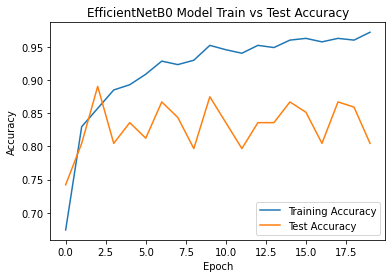

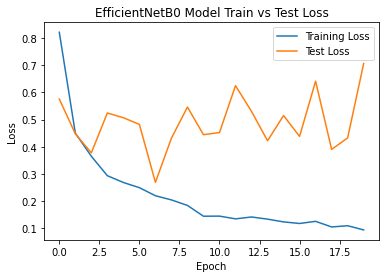

<Figure size 432x288 with 0 Axes>

In [14]:
# evaluation
predictions = moodel.predict(testX, batch_size=64)
print(classification_report(testY.argmax(axis=1),
                            predictions.argmax(axis=1), target_names=lb.classes_))
N = 20
plt.plot(np.arange(0, N), H.history['accuracy'], label="Training Accuracy")
plt.plot(np.arange(0, N), H.history['val_accuracy'], label="Test Accuracy")
plt.title('EfficientNetB0 Model Train vs Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()
plt.savefig(".\Accuracy_Plot_EffNetB0.png")
plt.plot(H.history['loss'], label="Training Loss")
plt.plot(H.history['val_loss'], label="Test Loss")
plt.title('EfficientNetB0 Model Train vs Test Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()
plt.savefig(".\Loss_Plot_EffNetB0.png")

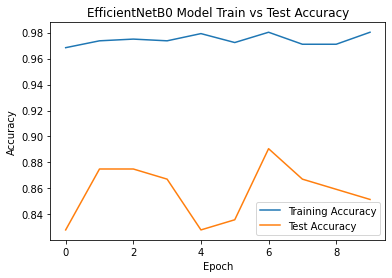

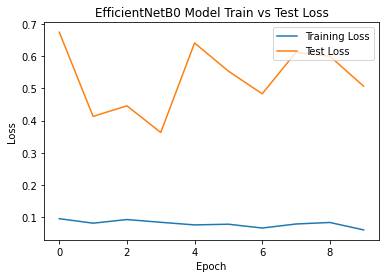

<Figure size 432x288 with 0 Axes>

In [15]:
N = 10
plt.plot(np.arange(0, N), H1.history['accuracy'], label="Training Accuracy")
plt.plot(np.arange(0, N), H1.history['val_accuracy'], label="Test Accuracy")
plt.title('EfficientNetB0 Model Train vs Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()
plt.savefig(".\Accuracy_Plot_EffNetB0.png")
plt.plot(H1.history['loss'], label="Training Loss")
plt.plot(H1.history['val_loss'], label="Test Loss")
plt.title('EfficientNetB0 Model Train vs Test Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()
plt.savefig(".\Loss_Plot_EffNetB0.png")

In [18]:
H2 = moodel.fit(
    trainAug.flow(trainX, trainY, batch_size=64),
    steps_per_epoch=len(trainX) // 64,
    validation_data=valAug.flow(testX, testY),
    validation_steps=len(testX) // 64,
    epochs=25)

Epoch 1/25
12/12 [==============================] - 28s 2s/step - loss: 0.0487 - accuracy: 0.9881 - val_loss: 0.5620 - val_accuracy: 0.8438
Epoch 2/25
12/12 [==============================] - 24s 2s/step - loss: 0.0722 - accuracy: 0.9740 - val_loss: 0.5437 - val_accuracy: 0.8594
Epoch 3/25
12/12 [==============================] - 25s 2s/step - loss: 0.0579 - accuracy: 0.9749 - val_loss: 0.5813 - val_accuracy: 0.8516
Epoch 4/25
12/12 [==============================] - 24s 2s/step - loss: 0.0607 - accuracy: 0.9749 - val_loss: 0.6113 - val_accuracy: 0.8516
Epoch 5/25
12/12 [==============================] - 24s 2s/step - loss: 0.0634 - accuracy: 0.9815 - val_loss: 0.4441 - val_accuracy: 0.8906
Epoch 6/25
12/12 [==============================] - 24s 2s/step - loss: 0.0565 - accuracy: 0.9776 - val_loss: 0.5125 - val_accuracy: 0.8516
Epoch 7/25
12/12 [==============================] - 24s 2s/step - loss: 0.0682 - accuracy: 0.9802 - val_loss: 0.4942 - val_accuracy: 0.8750
Epoch 8/25
12/12 [==

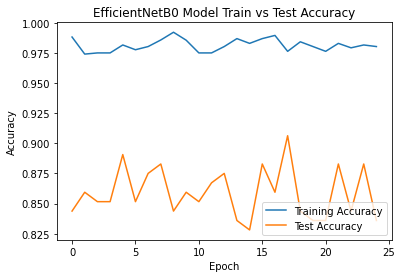

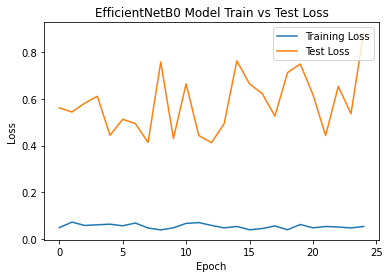

<Figure size 432x288 with 0 Axes>

In [19]:
N = 25
plt.plot(np.arange(0, N), H2.history['accuracy'], label="Training Accuracy")
plt.plot(np.arange(0, N), H2.history['val_accuracy'], label="Test Accuracy")
plt.title('EfficientNetB0 Model Train vs Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()
plt.savefig(".\Accuracy_Plot_EffNetB0.png")
plt.plot(H2.history['loss'], label="Training Loss")
plt.plot(H2.history['val_loss'], label="Test Loss")
plt.title('EfficientNetB0 Model Train vs Test Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()
plt.savefig(".\Loss_Plot_EffNetB0.png")